# Scratch

#### histogram interaction model parameter values

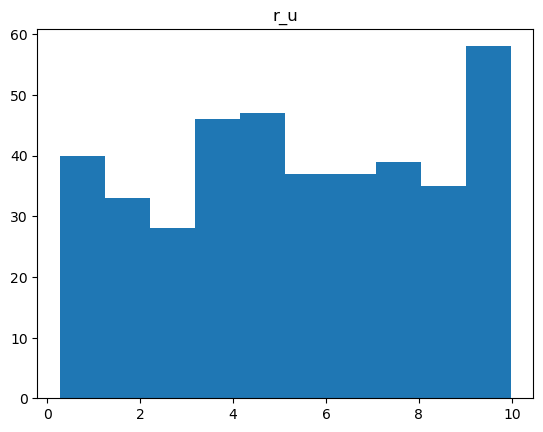

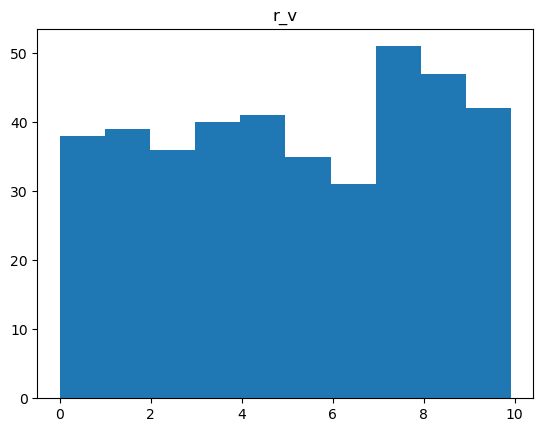

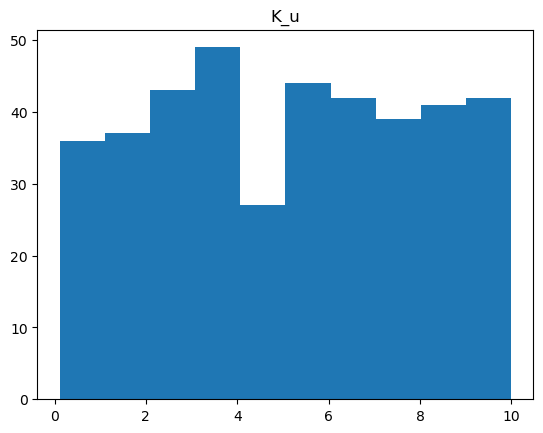

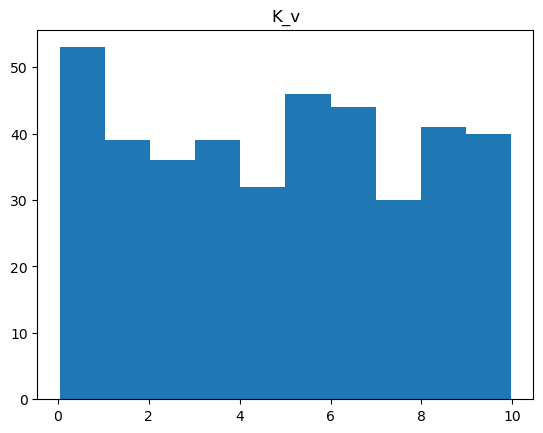

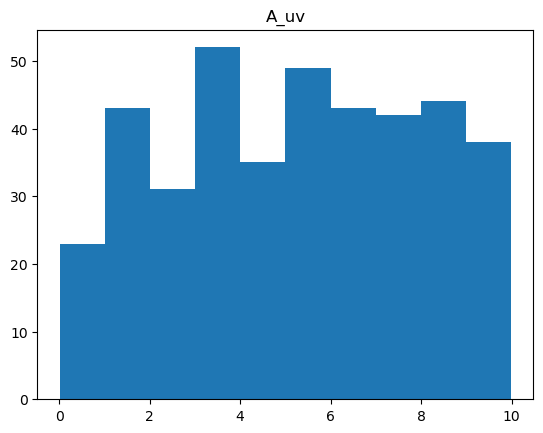

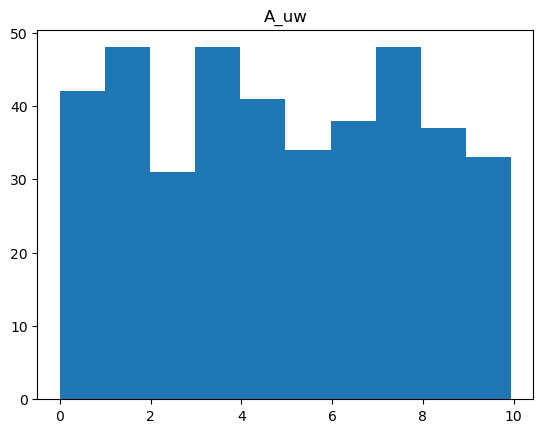

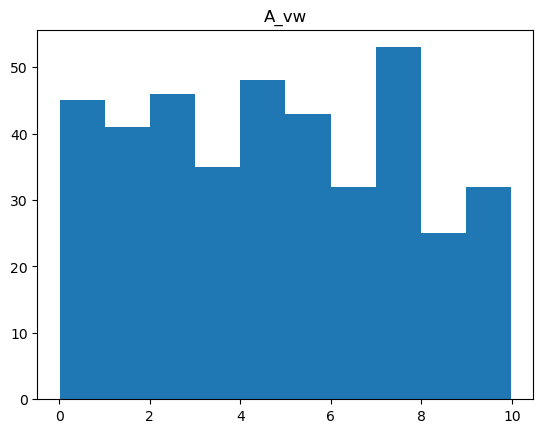

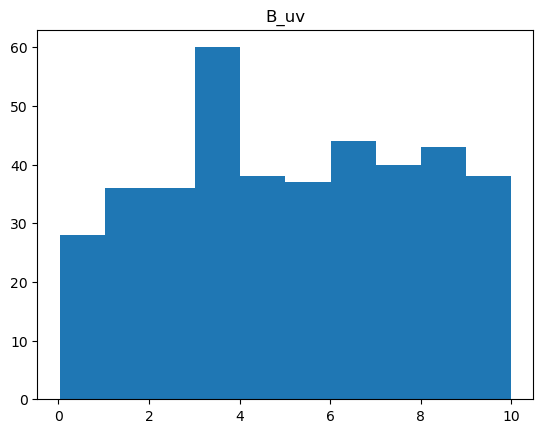

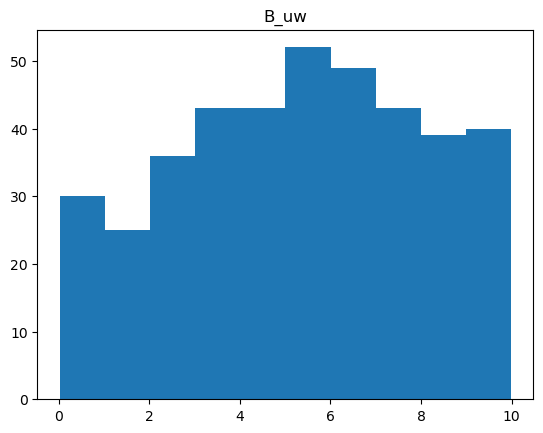

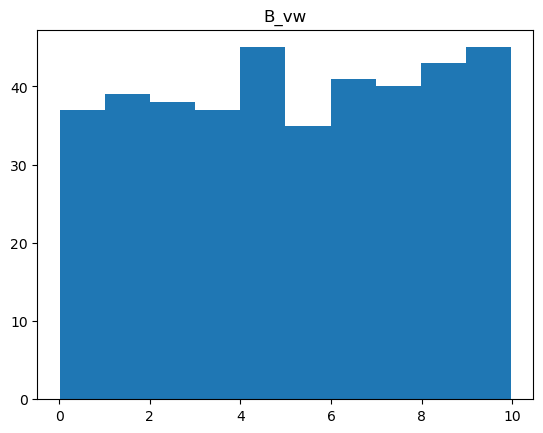

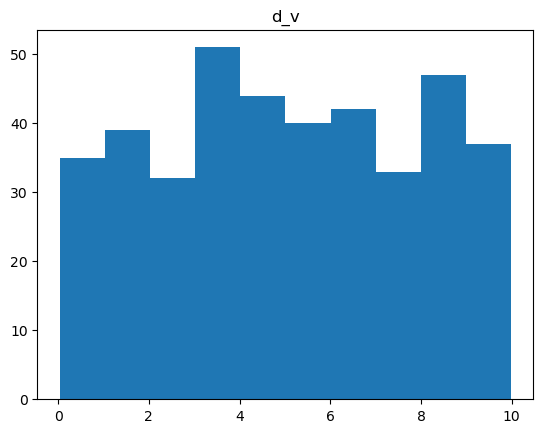

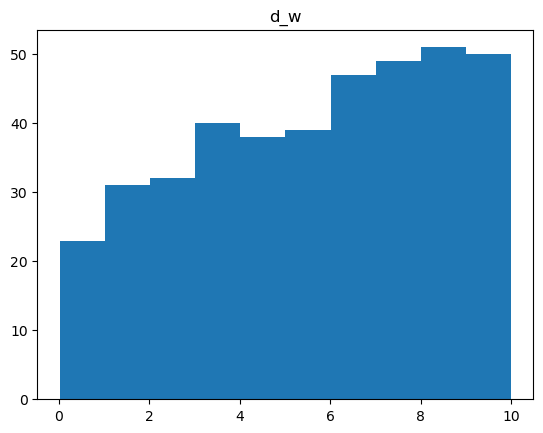

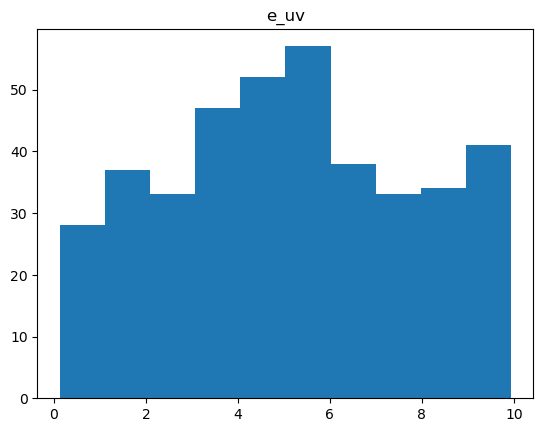

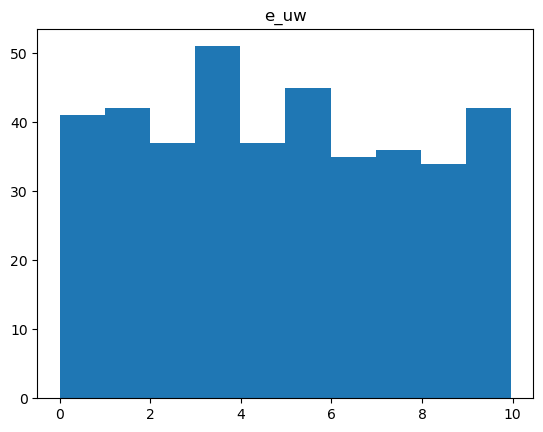

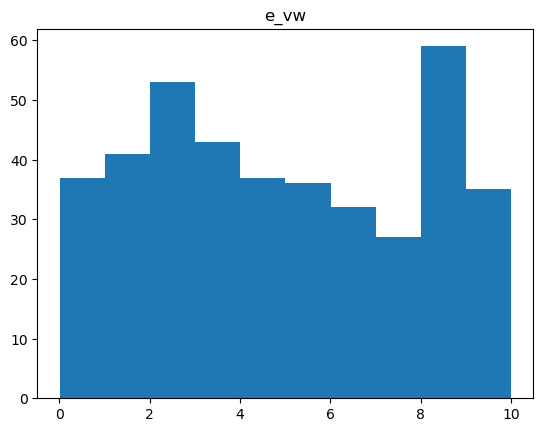

In [118]:
model_params = ['r_u', 'r_v', 'K_u', 'K_v', 'A_uv', 'A_uw', 'A_vw', 'B_uv', 'B_uw', 'B_vw', 'd_v', 'd_w', 'e_uv', 'e_uw', 'e_vw']
for p in model_params:
    p_vals = np.array(list(project.detect_schema()['model_params.'+p][float]))
    plt.hist(p_vals)
    plt.title(p)
    plt.show()

#### histogram Jacobian elements for each module

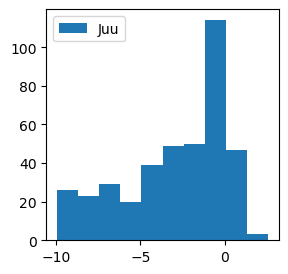

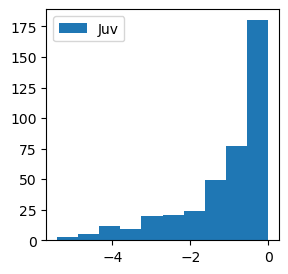

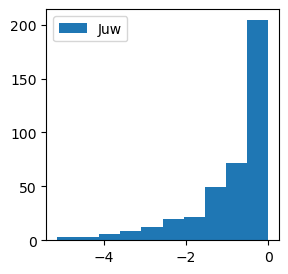

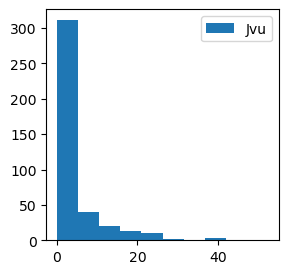

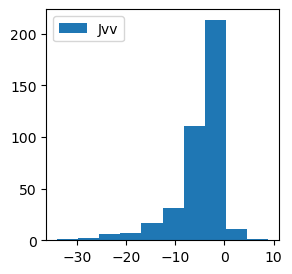

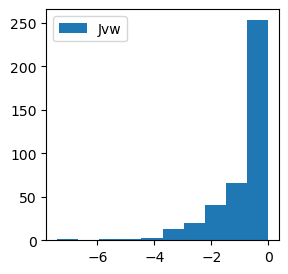

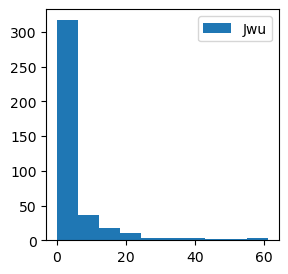

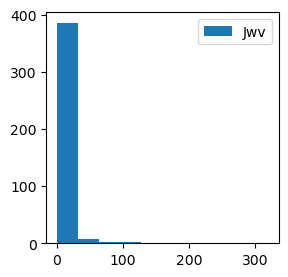

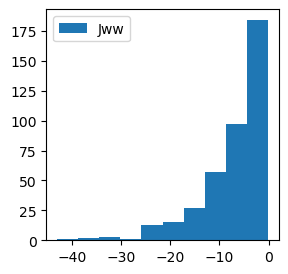

In [119]:
labels = ['Juu', 'Juv', 'Juw', 
          'Jvu', 'Jvv', 'Jvw',
          'Jwu', 'Jwv', 'Jww']
# for module in modules:
#     print(module,'---------------------------------------------')
#     all_Js = []
#     for job in project.find_jobs({'doc.surface_generated': True, 'module': module}):
#         with job.data as data:
#             J = np.array(data['J'])
#             all_Js.append(J.flatten())
#     all_Js = np.array(all_Js)
#     for i in range(9):
#         plt.figure(figsize=(3,3))
#         plt.hist(all_Js[:,i], label=labels[i])
#         plt.legend()
#         plt.show()

all_Js = []
for job in project.find_jobs({'doc.surface_generated': True}):
    with job.data as data:
        J = np.array(data['J'])
        all_Js.append(J.flatten())
all_Js = np.array(all_Js)
for i in range(9):
    plt.figure(figsize=(3,3))
    plt.hist(all_Js[:,i], label=labels[i])
    plt.legend()
    plt.show()

# Prep

## Imports and initializations

In [1]:
import numpy as np
import signac as sg
import pickle
from itertools import product, combinations, accumulate, groupby
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from project import spherical_to_cartesian

In [2]:
project = sg.get_project()
# List offdiagonal elements in desired sorted order for plotting/analysis
C_offdiags = [[[0,1]], [[0,2]],
              [[1,0]], [[1,2]],
              [[2,0]], [[2,1]]]
spec_labels = ['u', 'v', 'w']
C_offdiags_labels = [r'$C_{{{}{}}}$'.format(spec_labels[C_ij[0][0]], spec_labels[C_ij[0][1]]) for C_ij in C_offdiags]
# Read in module info from shared data
sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    adj_mats = np.array(sd['adj_mats'])
    modules = np.array([i.decode() for i in sd['modules']])
diagrams = ['w\n|\nv\n|\nu', 'w   v\n \ /\n  u', '  w\n / \\\nu   v', '  w\n / \\\nu - v']

## Define functions

### Read in data

In [ ]:
def init_data(param_i):
    # Organize data into a dict with top key level of modules
    data = {}
    subkeys = ['nocross_omega', 'nocross_omega_sec_mat', 'omega_mat', 'omega_sec_mats']
    for module in modules:
        data.update({module: {}})
    for module_i, module in enumerate(modules):
        omega_mat = np.zeros((3,3))
        omega_sec_mats = []

        for C_offdiag in [[]] + C_offdiags:
            # Find and open the raw data
            for job in project.find_jobs({'module': module, 'C_ijs': C_offdiag, 'param_i': param_i}):
                with job.data:
                    if C_offdiag == []:
                        omega_sum = 0.0
                        omega_sec_mat = np.zeros((2,4))
                        # Loop over parameter space sections
                        for phi_lims in product(range(2), range(4)):
                            conds = []
                            for lim_i, lim in enumerate(phi_lims):
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) > lim*np.pi/2)
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) < (lim + 1)*np.pi/2)
                            cond = np.all(conds, axis=0)
                            omega_integrand_sec = np.array(job.data['omega_integrand/wav'])[cond] + np.array(job.data['omega_integrand/st'])[cond]
                            i, j = phi_lims
                            omega_sec_mat[i, j] = sum(omega_integrand_sec) / sum(cond)
                            omega_sum += sum(omega_integrand_sec)
                        omega = omega_sum / len(job.data['phi_1'])
                        data[module].update({'nocross_omega': omega})
                        data[module].update({'nocross_omega_sec_mat': omega_sec_mat})
                    else: 
                        omega_sum = 0.0
                        omega_sec_mat = np.zeros((2,2,4))
                        # Loop over parameter space sections 
                        for phi_lims in product(range(2), range(2), range(4)):
                            conds = []
                            for lim_i, lim in enumerate(phi_lims):
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) > lim*np.pi/2)
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) < (lim + 1)*np.pi/2)
                            cond = np.all(conds, axis=0)
                            omega_integrand_sec = np.array(job.data['omega_integrand/wav'])[cond] + np.array(job.data['omega_integrand/st'])[cond]
                            i, j, k = phi_lims
                            omega_sec_mat[i, j, k] = sum(omega_integrand_sec) / sum(cond)
                            omega_sum += sum(omega_integrand_sec)
                        omega_sec_mats.append(omega_sec_mat)
                        i, j = job.sp['C_ijs'][0]
                        omega_mat[i, j] = (omega_sum / len(job.data['phi_1'])) 
                        data[module].update({'omega_mat': omega_mat})
        data[module].update({'omega_sec_mats': omega_sec_mats})
    return data

### Plotting

In [ ]:
def heatmap(data, row_labels, col_labels, ax, fig,
            xlabel="", ylabel="", title="", cbarlabel="", 
            savefig=False, fn='', path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/',
            **kwargs):
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.8)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, fontsize=15, labelpad=20)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_title(title, fontsize=20)
    if savefig:
        if fn == '':
            fn = str(int(np.random.sample()*1e5))+'.png'
        fig.savefig(path + fn)

def heatmap_sub(data, row_labels, col_labels, ax,
            xlabel="", ylabel="", title="", cbarlabel="", 
            axt=False, xtlabels=[], xtlabel="", **kwargs):
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.8)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, fontsize=20, labelpad=20)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    if axt:
        ax_t = ax.secondary_xaxis('top')
        ax_t.set_xticks(np.arange(data.shape[1]))
        ax_t.set_xticklabels(xtlabels, fontsize=12)
        ax_t.set_xlabel(xtlabel, fontsize=20)
    if title != "":
        ax.set_title(title, fontsize=20)

# Many parameterizations

In [3]:
df = project.to_dataframe(sp_prefix='', doc_prefix='', flatten=True)
model_params = [p for p in list(project.detect_schema()) if 'model_params' in p]
cross_colors = ['mediumblue', 'cornflowerblue', 'green', 'yellowgreen', 'orangered', 'lightcoral']

## Recreate random matrix plot

In [4]:
droplabs = [key for key in df.columns if 'omega_constrained' not in key]
for module in modules:
    print(module)
    df_sub = df[df['module'] == 'omnivory'].drop(labels = droplabs, axis=1)
    means = np.array(df_sub.mean())
    print(means)

chain
[3.06993036e-04 3.53472433e-03 4.56686819e-02 1.03119126e-01
 4.29127258e-01 4.81583478e-01 3.11551792e-01 4.99594421e-02
 2.32921802e-01 3.09817190e-01 2.66998694e-01 7.58668874e-01
 7.48793495e-01 2.61122518e-01 2.98861066e-02 6.55480848e-02
 1.01774392e-01 4.31511010e-03 5.89122450e-02 5.02074116e-01
 5.37943180e-01 6.82418557e-02 1.20907276e-02 2.06421894e-02
 1.20708127e-02 2.65702705e-01 8.80214833e-01 8.42679549e-01
 2.49280502e-01 1.36205990e-01 2.26745455e-01 1.40586964e-03
 1.32238068e-02 1.71502614e-01 2.66802312e-01 2.33690348e-01
 6.11674262e-01 7.21746141e-01 1.52483857e-01 5.60434004e-01
 6.95892372e-01 2.18280222e-02 3.74579523e-02 7.00792105e-02
 1.11058718e-01 1.60623780e-02 7.80101964e-02 1.79266902e-01
 8.45171452e-03 1.25356319e-02 1.55581902e-01 1.21144625e-01
 2.87016233e-02 1.50992364e-02 1.13963023e-01 1.02313269e-01
 2.07312170e-02 2.22313222e-01 1.76582670e-01 2.83106306e-02
 3.96867349e-03 6.89172419e-03 4.11977795e-03            nan]
exploitative
[3.0

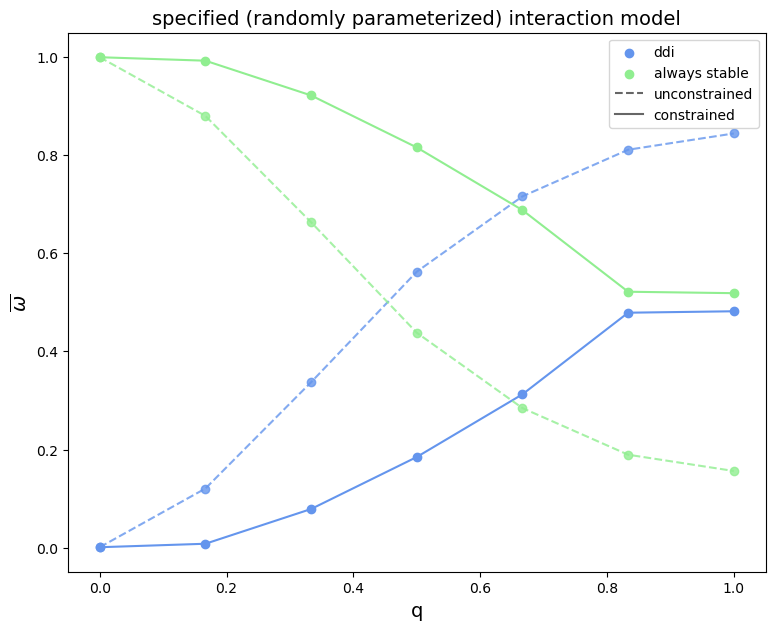

In [5]:
'''Test constraining to omnivory'''
df = df[df['module'] == 'omnivory']
''''''
savefig = False
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'average_omega.png'
plt.figure(figsize=(9,7))
ax = plt.subplot()
colors = ('lightgreen', 'cornflowerblue')
# Define q values which yield mean (expected) values for each
# possible number of nonzero cross diffusive elements
q_expected_arr = np.linspace(0, 1, len(C_offdiags)+1)
n_cross_arr = np.arange(0, len(C_offdiags)+1)
omega_con_means = np.zeros(len(q_expected_arr))
omega_uncon_means = np.zeros(len(q_expected_arr))
for q, n_cross in zip(q_expected_arr, n_cross_arr):
    # Get column labels for data with n_cross nonzero offdiagonal C elements
    if n_cross == 0:
        cross_labels = ['diag']
    else:
        cross_combs = [comb for comb in combinations(C_offdiags, n_cross)]
        cross_labels = []
        for cross_comb in cross_combs:
            '''Do I need to fix this in project.py?'''
            cross_comb = np.array((cross_comb))[:,0]
            cross_label = ','.join([str(c[0])+str(c[1]) for c in cross_comb])
            cross_labels.append(cross_label)
    
    # Calculate average value of omega for all scenarios
    unconstrained_averages = []
    constrained_averages = []
    for cross_label in cross_labels:
        uncon_label = 'omega_unconstrained.' + cross_label
        con_label = 'omega_constrained.' + cross_label
        uncon_avg = df[uncon_label].mean()
        con_avg = df[con_label].mean() 
        unconstrained_averages.append(uncon_avg)
        if cross_label == 'diag':
            constrained_averages.append(uncon_avg)
        else:
            constrained_averages.append(con_avg)
    omega_con_means[q_expected_arr == q] = np.mean(constrained_averages)
    omega_uncon_means[q_expected_arr == q] = np.mean(unconstrained_averages)
# Plot ddi
alp = 0.8
ax.plot(q_expected_arr, omega_uncon_means, ls='--', c=colors[1], alpha=alp)
ax.scatter(q_expected_arr, omega_uncon_means, c=colors[1], alpha=alp)
ax.plot(q_expected_arr, omega_con_means, c=colors[1])
ax.scatter(q_expected_arr, omega_con_means, c=colors[1], label='ddi')
# Plot always stable (1-ddi)
ax.plot(q_expected_arr, 1 - omega_uncon_means, ls='--', c=colors[0], alpha=alp)
ax.scatter(q_expected_arr, 1 - omega_uncon_means, c=colors[0], alpha=alp)
ax.plot(q_expected_arr, 1 - omega_con_means, c=colors[0])
ax.scatter(q_expected_arr, 1 - omega_con_means, c=colors[0], label='always stable')
# Add labels
ax.plot([], [], ls='--', alpha=0.6, color='black', label='unconstrained')
ax.plot([], [], alpha=0.6, color='black', label='constrained')
ax.legend()
ax.set_xlabel('q', fontsize=14)
ax.set_ylabel(r'$\overline{\omega}$', fontsize=14)
ax.set_title('specified (randomly parameterized) interaction model', fontsize=14)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

## Parameter sensitivities 

In [ ]:
savefig = True
p_arr = np.arange(11)
step = p_arr[-1] - p_arr[-2]
rows, columns = (model_params, modules)
n_cross_arr = np.arange(1, len(C_offdiags)+1)
legend_sizes = [30,12,10,12,25,25]
for n_cross in n_cross_arr:
    if n_cross == 0:
        cross_combs = [[]]
    else:
        cross_combs = [comb for comb in combinations(C_offdiags, n_cross)]
    
    # Get labels for different cross diffusive scenarios
    cross_labels = []
    for cross_comb in cross_combs:
        '''Do I need to fix this in project.py?'''
        cross_comb = np.array((cross_comb))[:,0]
        cross_label = ','.join([str(c[0])+str(c[1]) for c in cross_comb])
        cross_labels.append(cross_label)
        
    plt.figure(figsize=(8*len(columns), 6*len(rows)))
    for module_i, module in enumerate(modules):
        for p_i, p in enumerate(model_params):
            fig_n = p_i * len(columns) + module_i + 1
            ax = plt.subplot(len(rows), len(columns), fig_n)
            
            # Collect the data for each cross diffusive scenario
            omega_diffs = {cl: [] for cl in cross_labels}
            for pv_i in range(len(p_arr)-1):
                df_sub = df[(df['module'] == module) & (df[p] >= p_arr[pv_i]) & (df[p] < p_arr[pv_i+1])]
                for cl in cross_labels:
                    omega_con_avg = df_sub['omega_constrained.'+cl].mean()
                    omega_uncon_avg = df_sub['omega_unconstrained.'+cl].mean()
                    omega_diffs[cl].append(omega_con_avg - omega_uncon_avg)
                    
            # Plot each scenario
            for cross_i, cl in enumerate(cross_labels):
                label = [r'C_{{{}{}}}'.format(spec_labels[int(ij[0])], spec_labels[int(ij[1])]) for ij in cl.split(',')]
                label = r'$' + ','.join(label) + ' \\neq 0$'
                ax.scatter(p_arr[:-1] + step/2, omega_diffs[cl])
                ax.plot(p_arr[:-1] + step/2, omega_diffs[cl], label=label)
            ax.set_xlabel(p.replace('model_params.', ''), fontsize=14)
            # ax.set_ylabel(r'$\omega_{constrained} - \omega_{unconstrained}$', fontsize=14)
            if p_i == 0:
                ax.set_title(module, fontsize=20)
        #     break
        # break
    if savefig:
        path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
        fn='omega_diff_params_cross{}.png'.format(n_cross)
        plt.savefig(path + fn, bbox_inches='tight')
        
    # Plot legend separately
    label_params = ax.get_legend_handles_labels() 
    figl, axl = plt.subplots()
    size_i = np.nonzero(n_cross_arr == n_cross)[0][0]
    axl.axis(False)
    axl.legend(*label_params, loc="center", bbox_to_anchor=(0.5, 0.5), 
               prop={"size":legend_sizes[size_i]})
    if savefig:
        path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
        fn='omega_diff_legend_ncross{}.png'.format(n_cross)
        figl.savefig(path+fn)

## Pulling examples out

In [ ]:
C_ij_idx = 3
C_ij = C_offdiags[C_ij_idx][0]
outfn = 'nonzero_C{}{}_destabilization.csv'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]])
ascending = False # To sort from most destabilizing to most stabilizing 
df_sub = df[cross_matches[C_ij_idx] & (df['module'] == 'chain')].copy()
df_sub.sort_values(by='con_minus_uncon', ascending=ascending, inplace=True)
df_sub.drop(labels=['surface_generated', 'data_processed', 'param_i', 'N_n'], axis=1, inplace=True)
C_ijs = np.array([list(C_ijs[0]) for C_ijs in df_sub['C_ijs']])
df_sub.insert(1, 'C_offdiag_i', C_ijs[:,0])
df_sub.insert(2, 'C_offdiag_j', C_ijs[:,1])
x0s = np.array([list(x0) for x0 in df_sub['x0']])
df_sub.insert(4, 'steady_state_u', x0s[:,0])
df_sub.insert(5, 'steady_state_v', x0s[:,1])
df_sub.insert(6, 'steady_state_w', x0s[:,2])
df_sub.drop(labels=['C_ijs', 'x0', 'con_minus_uncon'], axis=1, inplace=True)
new_cols = [col.replace('model_params.', '') for col in list(df_sub.columns)]
df_sub.columns = new_cols

In [ ]:
st_coords, wav_coords, stab_coords = ([], [], [])
for row_i, jobid in enumerate(df_sub.index):
    job = project.open_job(id=jobid)
    with job.data:
        st = np.array(job.data['omega_integrand']['st'])
        wav = np.array(job.data['omega_integrand']['wav'])
        stab = np.array(job.data['omega_integrand']['stab'])
        phi_1 = np.array(job.data['phi_1'])
        phi_2 = np.array(job.data['phi_2'])
        phi_3 = np.array(job.data['phi_3'])
        ang_coord_samples = np.hstack((phi_1.reshape((len(phi_1), 1)), 
                                       phi_2.reshape((len(phi_2), 1)), 
                                       phi_3.reshape((len(phi_3), 1))))
        cart_coord_samples = []
        for ang_coord_sample in ang_coord_samples:
            cart_coord_samples.append(spherical_to_cartesian(ang_coord_sample))
        cart_coord_samples = np.array(cart_coord_samples)
        # Select samples where diagonal C elements are similar
        # mean, dev = (0.5, 0.2)
        # cond = (cart_coord_samples[:,1] > mean - dev) & (cart_coord_samples[:,1] < mean + dev) & (cart_coord_samples[:,2] > mean - dev) & (cart_coord_samples[:,2] < mean + dev) & (cart_coord_samples[:,3] > mean - dev) & (cart_coord_samples[:,3] < mean + dev)
    try:
        st_coords.append(cart_coord_samples[st][0])
    except:
        st_coords.append([np.nan for i in range(3)])
    try:
        wav_coords.append(cart_coord_samples[wav][0])
    except:
        wav_coords.append([np.nan for i in range(3)])
    try:
        stab_coords.append(cart_coord_samples[stab][0])
    except:
        stab_coords.append([np.nan for i in range(3)])
st_coords = np.array(st_coords)
wav_coords = np.array(wav_coords)
stab_coords = np.array(stab_coords)
df_sub['stat_ddi_C{}{}'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]])] = st_coords[:,0]
df_sub['stat_ddi_Cuu'] = st_coords[:,1]
df_sub['stat_ddi_Cvv'] = st_coords[:,2]
df_sub['stat_ddi_Cww'] = st_coords[:,3]
df_sub['stable_C{}{}'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]])] = stab_coords[:,0]
df_sub['stable_Cuu'] = stab_coords[:,1]
df_sub['stable_Cvv'] = stab_coords[:,2]
df_sub['stable_Cww'] = stab_coords[:,3]
df_sub.reset_index(drop=True, inplace=True)
df_sub.to_csv(outfn)

In [ ]:
import pandas as pd
df_test = pd.read_csv(outfn)
df_test

# Single parameterization

## Initialize data

In [ ]:
data = init_data(1)

## omega C_ij

In [ ]:
savefig = False
plt.figure( figsize=(6*len(modules), 5*2) )
xticks = ['r','n','p']
yticks = ['r','n','p']
for module_i, module in enumerate(modules):
    nocross_omega = data[module]['nocross_omega']
    omega_mat = data[module]['omega_mat']
    n = module_i + 1
    ax = plt.subplot(2, len(modules), n)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
    heatmap_sub(omega_mat, yticks, xticks, ax=ax, 
                cbarlabel=r"$\omega_{ddi}$", cmap="Blues", norm=norm,
                title="{}".format(module))
    n = len(modules) + module_i + 1
    ax = plt.subplot(2, len(modules), n)
    omega_diff_mat = omega_mat - nocross_omega*(-1.*(np.eye(3)-1))
    bound = 0.275
    norm = colors.TwoSlopeNorm(vmin=-bound, vcenter=0, vmax=bound)
    heatmap_sub(omega_diff_mat, yticks, xticks, ax=ax, 
                cbarlabel=r"$\Delta\omega_{ddi}$", cmap="RdBu", norm=norm)
                # title="Delta omega {}".format(module))

if savefig:
    path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    fn='omega_Cij.png'
    plt.savefig(path + fn, bbox_inches='tight')

## omega per section

In [ ]:
savefig = False
from matplotlib import cm, colors
plt.figure( figsize=(10*len(modules), 5*(len(C_offdiags) + 1)) )
xticks = ['C22<0','C22>0','C22>0','C22<0']
xtticks = ['C33<0', 'C33<0', 'C33>0', 'C33>0']
yticks = ['C11<0','C11>0']
for module_i, module in enumerate(modules):
    nocross_omega_sec_mat = data[module]['nocross_omega_sec_mat']
    omega_sec_mats = data[module]['omega_sec_mats']
    n = module_i + 1
    ax = plt.subplot(len(C_offdiags)+1, len(modules), n)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
    cmap = 'Blues'
    heatmap_sub(nocross_omega_sec_mat, yticks, xticks, ax=ax, axt=True, xtlabels=xtticks,
            cbarlabel=r"$\omega_{dii}$", cmap="Blues", norm=norm,
            title="{} module\nno cross-diffusion".format(module))

    # for i in range(len(C_offdiags)):
    for C_offdiag_i, C_offdiag in enumerate(C_offdiags):
        C_offdiag = C_offdiag[0]
        mean_omega_sec_mat = np.mean(omega_sec_mats[C_offdiag_i], axis=0)
        norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
        cmap = 'Blues'
        # Cij = "C{}{}".format(str(C_offdiags[i][0]+1), str(C_offdiags[i][1]+1))
        i, j = C_offdiag
        n = (C_offdiag_i + 1)*len(modules) + module_i + 1
        ax = plt.subplot(len(C_offdiags)+1, len(modules), n)
        heatmap_sub(mean_omega_sec_mat, yticks, xticks, ax=ax, 
                    axt=True, xtlabels=xtticks,
                    cbarlabel=r"$\omega_{dii}$", cmap="Blues", norm=norm, 
                    title=r'$C_{{{}{}}} \neq 0$'.format(spec_labels[i], spec_labels[j]))

if savefig:
    path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    fn='omega_sec.png'
    plt.savefig(path + fn, bbox_inches='tight')

## Phase

In [ ]:
for param_i in np.arange(2,3):
    savefig = False
    # param_i = 100
    figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    figfn = 'phase_nocross_{}.png'.format(param_i)
    path = project.path.split('/')[:-1]
    plt.figure( figsize=(10*len(modules), 5) )
    for module_i, module in enumerate(modules):
        n = module_i + 1
        ax = plt.subplot(1, len(modules), n)
        for job in project.find_jobs({'module': module, 'C_ijs': [], 'param_i': int(param_i)}):
            print(job.id)
            with job.data as nocross_data:
                st = np.array(nocross_data['omega_integrand/st'])
                wav = np.array(nocross_data['omega_integrand/wav'])
                stab = np.array(nocross_data['omega_integrand/stab'])
                xs = np.array(nocross_data['phi_2'])
                ys = np.array(nocross_data['phi_1'])
            colors = []
            for i in range(len(st)):
                if st[i]: colors.append('cornflowerblue')
                elif wav[i]: colors.append('lightcoral')
                # elif wav[i]: colors.append('cornflowerblue')
                elif stab[i]: colors.append('lightgrey')
            lw = 3
            ls = '-'
            c ='black'
            alpha = 0.7
            ax_label_fontsize = 15
            xticks, yticks = ([0.], [0.])
            for phi_lims in product(range(2), range(4)):
                x = (phi_lims[1]+1)*np.pi/2
                xticks.append(x)
                y = (phi_lims[0]+1)*np.pi/2
                yticks.append(y)
                ax.axvline(x, c=c, linewidth=lw, ls=ls, alpha=alpha)
                ax.axhline(y, c=c, linewidth=lw, ls=ls, alpha=alpha)
            xticks = np.unique(xticks)
            yticks = np.unique(yticks)
            ax.scatter(xs, ys, c=colors)
            ax.set_title('{} module'.format(module), fontsize=15)
            ax.set_ylabel(r'$C_{uu}$', fontsize=ax_label_fontsize)
            ax.set_xlim(0,x)
            ax.set_ylim(0,y)
            ax.invert_yaxis()
            ax.set_yticks(yticks)
            ylabels = ['-1', '0', '1']
            ax.set_yticklabels(ylabels)
            ax.set_xticks(xticks)
            xblabels = ['-1', '0', '1', '0', '-1']
            ax.set_xticklabels(xblabels)
            ax.set_xlabel(r'$C_{vv}$', fontsize=ax_label_fontsize)
            ax_t = ax.secondary_xaxis('top')
            xtlabels = ['0', '-1', '0', '1', '0']
            ax_t.set_xticks(xticks)
            ax_t.set_xticklabels(xtlabels)
            ax_t.set_xlabel(r'$C_{ww}$', fontsize=ax_label_fontsize)

    if savefig:
        plt.savefig(figpath + figfn, bbox_inches='tight')

## Positive diagonal, constrained off-diagonal

In [ ]:
for param_i in np.arange(1,21):
    savefig = False
    plt.figure(figsize=(7*len(modules), 5))
    plt.suptitle('intraspecific dispersal > 0\ninterspecific dispersal constrained to opposite sign from interaction ', fontsize=15)
    for module_i, module in enumerate(modules):
        ax = plt.subplot(1, len(modules), module_i + 1)
        omega_con_arr = []
        omega_uncon_arr = []
        'Only include positive diagonal elements, sign of cross diffusion depends on interactions'
        for C_offdiag in [[]] + C_offdiags:
            for job in project.find_jobs({'module': module, 'C_ijs': C_offdiag, 'param_i': int(param_i)}):
                if C_offdiag == []:
                    with job.data:
                        nocross_omega_sec_mat = np.array(job.data['omega_sec_mat'])
                else:
                    omega_con_arr.append(job.doc['omega_constrained'])
                    omega_uncon_arr.append(job.doc['omega_unconstrained'])
                    # print(job.doc.omega_constrained)
                    # import sys; sys.exit()
        xs = range(len(omega_con_arr))
        ax.stem(xs, omega_uncon_arr, bottom=nocross_omega_sec_mat[1,2], basefmt='black', 
                linefmt='blueviolet')
        ax.scatter([],[],color='blueviolet', label=r'$C_{ij}$ unconstrained')
        ax.stem(xs, omega_con_arr, bottom=nocross_omega_sec_mat[1,2], basefmt='black', 
                linefmt='orange')
        ax.scatter([],[],color='orange', label=r'$C_{ij}$ constrained')
        ax.axhline(nocross_omega_sec_mat[1,2], color='black', label=r'baseline $\omega_{ddi}$')
        ax.set_xticks(xs)
        ax.set_xticklabels(C_offdiags_labels)
        legsize = 10
        xys = [(0.25, 0.9),(0.6, 0.9),(0.7, 0.9),(0.5, 0.9)]
        leglocs = [(0.6,0.6),(0.6,0.6),(0.6,0.6),(0.6,0.6)]
        ax.legend(loc=leglocs[module_i], prop={'size': legsize})
        ax.annotate(module+'\n'+diagrams[module_i], xy=xys[module_i], xycoords='data',
                size=14, ha='center', va='top',
                bbox=dict(boxstyle='round', fc='w', alpha=0.6)) 
        ax.set_ylim(-0.1,1.1)
        ax.set_ylabel(r'$\omega_{ddi}$', fontsize=15)
        ax.set_xlabel('cross-diffusive element', fontsize=15)

    if savefig:
        path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
        fn='omega_constrained.png'
        plt.savefig(path + fn, bbox_inches='tight')